## Numerical data crawling

In [144]:
import requests
import pandas as pd
import yfinance as yf
import time
import os

# --- CONFIGURATION ---
START_DATE = "2020-01-01"
END_DATE = "2025-12-01"

# LIST OF COINS TO CRAWL
# BTC, ETH, BNB, SOL, ADA
CRYPTO_SYMBOLS = ["BTCUSDT", "ETHUSDT", "BNBUSDT", "ADAUSDT", "LTCUSDT", "XRPUSDT"]

# MACRO TICKERS (ADDED NASDAQ & 10Y YIELD)
MACRO_CONFIG = {
    "SP500_Fut": "ES=F", # S&P 500 Futures
    "Nasdaq_Fut": "NQ=F",  # Nasdaq 100 Futures
    "DXY": "DX-Y.NYB", # US Dollar Index
    "VIX": "^VIX", # CBOE Volatility Index
    "Gold": "GC=F", # Gold Futures
    "US10Y": "^TNX" # US 10 Year Treasury Yield
}

# --- PART 1: BINANCE CRAWLER (DAILY) ---
def get_binance_daily(symbol, start_str, end_str):
    print(f"🚀 Fetching {symbol} Daily Data...")
    
    start_ts = int(pd.Timestamp(start_str).timestamp() * 1000)
    end_ts = int(pd.Timestamp(end_str).timestamp() * 1000)
    
    url = "https://api.binance.com/api/v3/klines"
    all_data = []
    current_start = start_ts
    
    while current_start < end_ts:
        params = {
            "symbol": symbol,
            "interval": "1d",
            "startTime": current_start,
            "endTime": end_ts,
            "limit": 1000
        }
        try:
            response = requests.get(url, params=params)
            data = response.json()
            
            # Handle empty response or API error
            if not isinstance(data, list) or not data: 
                break
                
            all_data.extend(data)
            last_close_time = data[-1][6]
            current_start = last_close_time + 1
            time.sleep(0.1)
        except Exception as e:
            print(f"❌ Error fetching {symbol}: {e}")
            break
            
    if not all_data:
        print(f"⚠️ No data found for {symbol}")
        return None

    cols = ['Open time','Open','High','Low','Close','Volume',
            'Close time','Quote asset volume','Trades',
            'Taker buy base','Taker buy quote','Ignore']
    df = pd.DataFrame(all_data, columns=cols)
    
    df['Open time'] = pd.to_datetime(df['Open time'], unit='ms')
    df['Date'] = df['Open time'].dt.normalize()
    
    numeric_cols = ['Open','High','Low','Close','Volume']
    df[numeric_cols] = df[numeric_cols].astype(float)
    
    df = df.set_index('Date')
    
    # Prefix columns with Coin Name (e.g., BTC_Close, ETH_Close)
    # Extract coin name from symbol (BTCUSDT -> BTC)
    coin_name = symbol.replace("USDT", "")
    df = df.rename(columns={
        'Close': f'{coin_name}_Close', 
        'Volume': f'{coin_name}_Volume',
        'Open': f'{coin_name}_Open', 
        'High': f'{coin_name}_High', 
        'Low': f'{coin_name}_Low'
    })
    
    df = df.sort_index().loc[start_str:end_str]
    return df[[f'{coin_name}_Close', f'{coin_name}_Volume', f'{coin_name}_High', f'{coin_name}_Low']]

# --- PART 2: YAHOO FINANCE CRAWLER (MACRO) ---
def download_macro_data(start_date, end_date):
    print("\n⬇️ Downloading Macro Data (Batch)...")
    macro_dfs = []
    
    for name, ticker in MACRO_CONFIG.items():
        try:
            df = yf.download(tickers=ticker, start=start_date, end=end_date, interval="1d", progress=False)
            
            if df.empty: continue
                
            if isinstance(df.columns, pd.MultiIndex):
                df.columns = df.columns.get_level_values(0)
            df.columns.name = None
            
            if df.index.tz is not None: 
                df.index = df.index.tz_localize(None)
            
            df.index = df.index.normalize()
            
            # Keep only Close price for macro
            df = df[['Close']].rename(columns={'Close': f'{name}_Close'})
            macro_dfs.append(df)
            print(f"   -> {name} loaded.")
        except Exception as e:
            print(f"❌ Error {name}: {e}")
            
    # Combine all macro data into one DataFrame
    if macro_dfs:
        full_macro = pd.concat(macro_dfs, axis=1)
        return full_macro
    return None

# --- PART 3: MAIN PROCESS ---
def main_crawl_process():
    if not os.path.exists('Data'): os.makedirs('Data')
    
    # 1. Download Macro Data ONCE (It's shared for all coins)
    df_macro = download_macro_data(START_DATE, END_DATE)
    
    if df_macro is None:
        print("Critical Error: Could not download Macro Data.")
        return

    # 2. Loop through each Crypto
    for symbol in CRYPTO_SYMBOLS:
        print(f"\n--- Processing {symbol} ---")
        
        # Get Crypto Data
        df_coin = get_binance_daily(symbol, START_DATE, END_DATE)
        
        if df_coin is not None:
            # Merge with Macro (Left Join on Coin Data)
            # This ensures we keep 24/7 crypto rows
            master_df = df_coin.join(df_macro, how="left")
            
            # Fill Gaps (Forward Fill for weekends/holidays)
            master_df = master_df.ffill().bfill()
            
            # Save individual file
            filename = f"Data/{symbol}_market_data.csv"
            master_df.to_csv(filename)
            print(f"✅ Saved: {filename}")
        else:
            print(f"⚠️ Skipping {symbol} due to missing data.")

if __name__ == "__main__":
    main_crawl_process()


⬇️ Downloading Macro Data (Batch)...
   -> SP500_Fut loaded.
   -> Nasdaq_Fut loaded.
   -> DXY loaded.
   -> VIX loaded.
   -> Gold loaded.
   -> US10Y loaded.

--- Processing BTCUSDT ---
🚀 Fetching BTCUSDT Daily Data...
✅ Saved: Data/BTCUSDT_market_data.csv

--- Processing ETHUSDT ---
🚀 Fetching ETHUSDT Daily Data...
✅ Saved: Data/ETHUSDT_market_data.csv

--- Processing BNBUSDT ---
🚀 Fetching BNBUSDT Daily Data...
✅ Saved: Data/BNBUSDT_market_data.csv

--- Processing ADAUSDT ---
🚀 Fetching ADAUSDT Daily Data...
✅ Saved: Data/ADAUSDT_market_data.csv

--- Processing LTCUSDT ---
🚀 Fetching LTCUSDT Daily Data...
✅ Saved: Data/LTCUSDT_market_data.csv

--- Processing XRPUSDT ---
🚀 Fetching XRPUSDT Daily Data...
✅ Saved: Data/XRPUSDT_market_data.csv


## Data Understanding


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

CRYPTO_LIST = ["BTC", "ETH", "BNB", "ADA", 'XRP', 'LTC'] # List of cryptocurrencies
FILES_MAP = {
    "BTC": "Data/BTCUSDT_market_data.csv",
    "ETH": "Data/ETHUSDT_market_data.csv",
    "BNB": "Data/BNBUSDT_market_data.csv",
    "ADA": "Data/ADAUSDT_market_data.csv",
    "XRP": "Data/XRPUSDT_market_data.csv",
    "LTC": "Data/LTCUSDT_market_data.csv"
}

def load_and_merge_returns():
    all_returns = pd.DataFrame()
    
    for coin, filepath in FILES_MAP.items(): 
        if os.path.exists(filepath):
            df = pd.read_csv(filepath, index_col="Date", parse_dates=True)
            
            # calculate daily returns (Price Later - Price Earlier) / Price Earlier
            col_name = f'{coin}_Close'
            if col_name in df.columns:
                ret_series = df[col_name].pct_change()
                all_returns[coin] = ret_series
            else:
                print(f"⚠️ Column {col_name} not found in {filepath}")

    all_returns = all_returns.dropna()
    return all_returns

df_rets = load_and_merge_returns()
df_rets
        
    

,BTC,ETH,BNB,ADA,XRP,LTC
Date,,,,,,
2020-01-02,-0.032654,-0.027376,-0.051602,-0.023596,-0.028749,-0.052619
2020-01-03,0.054445,0.056294,0.048953,0.045274,0.031360,0.071012
2020-01-04,0.001246,-0.001116,0.011856,0.004975,-0.001706,0.013024
2020-01-05,0.000631,0.008718,0.017669,0.007571,0.007666,0.012155
2020-01-06,0.054255,0.064859,0.063608,0.078613,0.146867,0.057737
...,...,...,...,...,...,...
2025-11-27,0.009393,-0.003744,0.004441,-0.005739,-0.010525,-0.003223
2025-11-28,-0.004853,0.005280,-0.009545,-0.030478,-0.009273,-0.027370
2025-11-29,-0.000971,-0.013853,-0.016107,-0.012384,0.009819,-0.003206


### Cumulative returns of cryptocurrencies

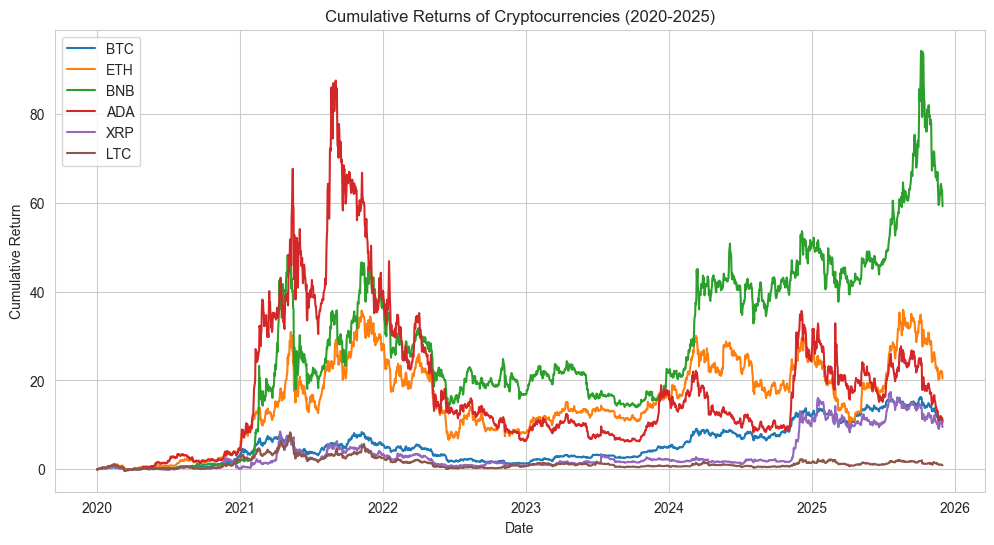

In [156]:
cumulative_returns = (1 + df_rets).cumprod() - 1

plt.figure(figsize=(12, 6))
for col in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[col], label=col, linewidth=1.5)

plt.title("Cumulative Returns of Cryptocurrencies (2020-2025)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.legend()
plt.show()


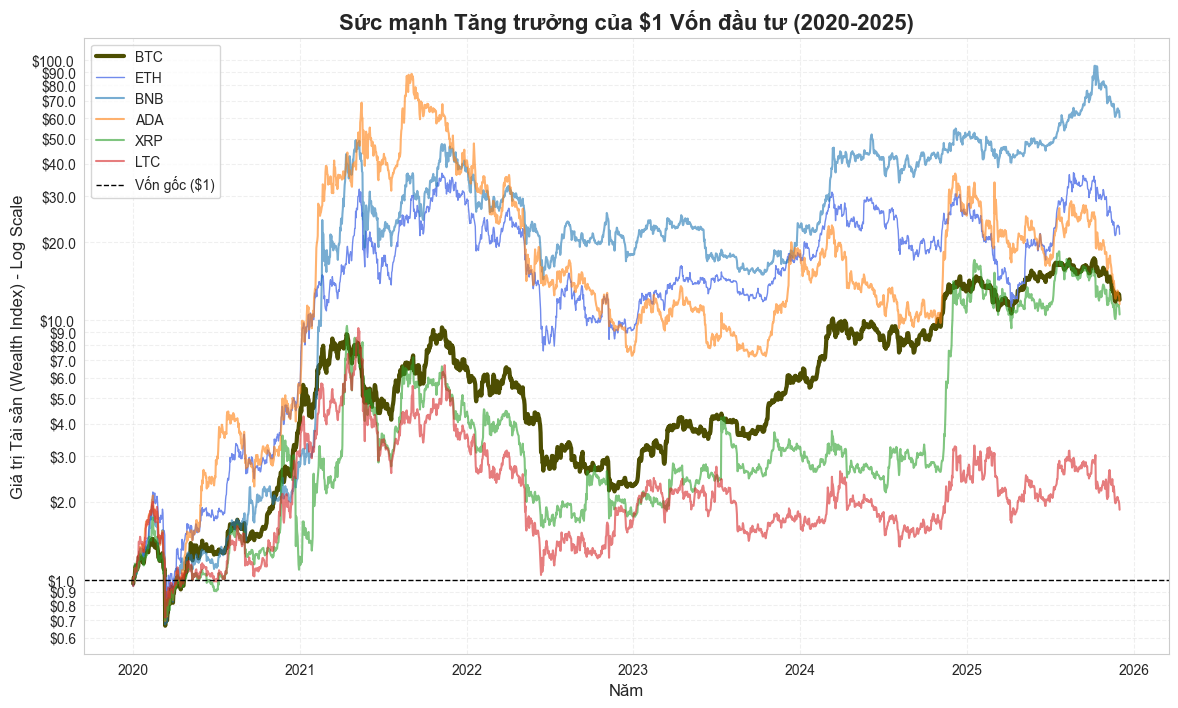

In [161]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

# Cài đặt style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 8)

# --- SỬA CÔNG THỨC: Wealth Index (Tăng trưởng của $1) ---
# Không trừ 1 nữa. Bắt đầu từ 1.
cumulative_wealth = (1 + df_rets).cumprod()

plt.figure()

# Vẽ các đường
for col in cumulative_wealth.columns:
    # Highlight BTC và ETH cho dễ nhìn
    if 'BTC' in col:
        plt.plot(cumulative_wealth.index, cumulative_wealth[col], label=col, linewidth=3, color="#4D4E02", alpha=1) # Màu cam Bitcoin
    elif 'ETH' in col:
        plt.plot(cumulative_wealth.index, cumulative_wealth[col], label=col, linewidth=1, color='#627EEA', alpha=0.9) # Màu xanh Ethereum
    else:
        plt.plot(cumulative_wealth.index, cumulative_wealth[col], label=col, linewidth=1.5, alpha=0.6)

# --- THIẾT LẬP LOG SCALE CHUẨN ---
plt.yscale('log')

# Format trục Y để hiển thị số tiền dễ đọc ($1, $10, $100)
# Thay vì hiển thị 10^0, 10^1
ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('$%.1f'))
ax.yaxis.set_minor_formatter(mtick.FormatStrFormatter('$%.1f'))

plt.title("Sức mạnh Tăng trưởng của $1 Vốn đầu tư (2020-2025)", fontsize=16, fontweight='bold')
plt.ylabel("Giá trị Tài sản (Wealth Index) - Log Scale", fontsize=12)
plt.xlabel("Năm", fontsize=12)

# Thêm đường tham chiếu $1 (Vốn gốc)
plt.axhline(y=1, color='black', linestyle='--', linewidth=1, label='Vốn gốc ($1)')

plt.legend(loc='upper left', fontsize=10)
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.show()